In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import matplotlib.image as mpimg #for image reading
import csv                       #for csv reading
from matplotlib import colors

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

## Pokemon constants:
NTYPES = 18

In [2]:
#enter file locations here!
CSVFILENAME  = 'dataset/pokemon.csv'
IMAGESFOLDER = 'dataset/images/images/'

In [3]:
## get data from csv file
with open(CSVFILENAME) as csvfileobj:
    csvreader = csv.reader(csvfileobj)
    csvdata = [row for row in csvreader]

In [118]:
## pad single-typed pokemon with a second type ('None')
pad = 'None'
paddata = np.array([row if len(row)==3 else row+[pad] for row in csvdata])
pokedata = paddata[1:]

## definitions for convenience (i.e. possibly useful definitions)
alltypes = np.sort(np.unique(paddata[1:, 1:3]))  #will include pad as a type though..
IDXTYPE = {alltypes[i]:str(i) for i in range(len(alltypes))}
TYPEIDX = {str(i):alltypes[i] for i in range(len(alltypes))}
idxdata = np.array([[row[0], IDXTYPE[row[1]], IDXTYPE[row[2]]] for row in pokedata])

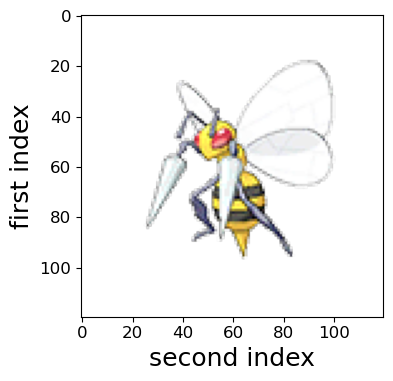

In [17]:
## load image
def get_image(pokename, folder=IMAGESFOLDER, ext='.png'):
    """returns image of pokemon named <pokename>."""
    return mpimg.imread(os.path.join(folder, pokename+ext))

#example:
imgdata = get_image('beedrill')
plt.imshow(imgdata)
plt.ylabel('first index')
plt.xlabel('second index')
plt.show()

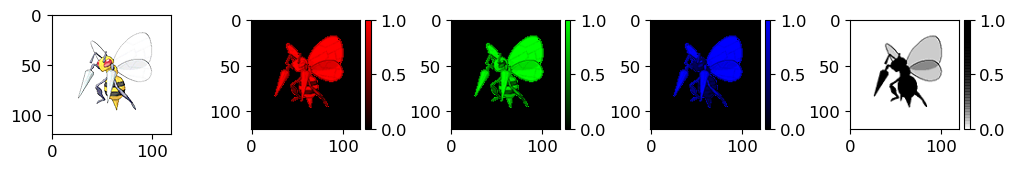

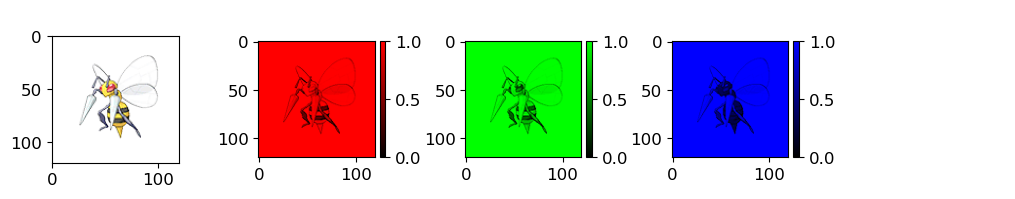

In [74]:
## images in true color channels (rgba), because we can.
def show_rgba(imgdata):
    z = np.zeros(256)
    l = np.linspace(0.0,1.0,256)
    Rcmap = colors.ListedColormap(np.array([l, z, z, z+1]).T)
    Gcmap = colors.ListedColormap(np.array([z, l, z, z+1]).T)
    Bcmap = colors.ListedColormap(np.array([z, z, l, z+1]).T)
    Acmap = colors.ListedColormap(np.array([z, z, z, l  ]).T)
    fig, axs = plt.subplots(1,5, figsize=(10,2))
    plt.sca(axs[0]); plt.imshow(imgdata)
    plt.sca(axs[1]); plt.imshow(imgdata[:,:,0], cmap=Rcmap); pqol.colorbar()
    plt.sca(axs[2]); plt.imshow(imgdata[:,:,1], cmap=Gcmap); pqol.colorbar()
    plt.sca(axs[3]); plt.imshow(imgdata[:,:,2], cmap=Bcmap); pqol.colorbar()
    plt.sca(axs[4]); plt.imshow(imgdata[:,:,3], cmap=Acmap); pqol.colorbar()
    plt.tight_layout(pad=0.1)
show_rgba(imgdata)

def img_to_rgb(imgdata):
    if imgdata.shape[-1]==4:
        imgrgb = imgdata[...,:-1]
        imga   = imgdata[...,-1:]
        background = colors.to_rgb('white')
        rgbdata = imgrgb * imga + (1-imga) * background
        rgbdata[rgbdata>1.0]=1.0    #max r,g,b value
    else:
        rgbdata = imgdata
    return rgbdata

def show_rgb(imgdata):
    rgbdata = img_to_rgb(imgdata)
    z = np.zeros(256)
    l = np.linspace(0.0,1.0,256)
    Rcmap = colors.ListedColormap(np.array([l, z, z, z+1]).T)
    Gcmap = colors.ListedColormap(np.array([z, l, z, z+1]).T)
    Bcmap = colors.ListedColormap(np.array([z, z, l, z+1]).T)
    fig, axs = plt.subplots(1,5, figsize=(10,2))
    plt.sca(axs[0]); plt.imshow(rgbdata)
    plt.sca(axs[1]); plt.imshow(rgbdata[:,:,0], cmap=Rcmap); pqol.colorbar()
    plt.sca(axs[2]); plt.imshow(rgbdata[:,:,1], cmap=Gcmap); pqol.colorbar()
    plt.sca(axs[3]); plt.imshow(rgbdata[:,:,2], cmap=Bcmap); pqol.colorbar()
    axs[4].axis('off')
    plt.tight_layout(pad=0.1)
show_rgb(imgdata);

## Get all the images of pokemon!

In [103]:
def get_image_and_poke(filename, folder=IMAGESFOLDER):
    name, ext = filename.split('.')
    ext = '.' + ext
    return get_image(name, folder=folder, ext=ext), name

In [ ]:
allimagenames = os.listdir(IMAGESFOLDER)
temp = [get_image_and_poke(name) for name in allimagenames]
allimages = {t[1]: t[0] for t in temp}
#now allimages is a dict with pokenames as keys and pokepics as images.

### Some pokemon images were pngs while some were jpgs. Convert all to jpgs.

In [95]:
#show_rgb(allimages['parasect']);
#show_rgb(allimages['charjabug']);
JPGSAVELOC = 'dataset/images/image_jpgs'
''' save all the images as jpgs
for pokemon in allimages.keys():
    plt.imsave(os.path.join(JPGSAVELOC, pokemon+'.jpg'), img_to_rgb(allimages[pokemon]))
#''';

### put pokemon images in order

In [104]:
pokemonnames = idxdata[:,0]
temp = [get_image_and_poke(name+'.jpg', folder=JPGSAVELOC) for name in pokemonnames]
alljpgs = {t[1]: t[0] for t in temp}

In [105]:
orderedimages = np.array([alljpgs[pokemon] for pokemon in idxdata[:,0]])

In [107]:
orderedimages.shape

(809, 120, 120, 3)

In [121]:
pokedata[:,1].shape  #primary types of pokes.

(809,)

## Single-type classification (the simplest problem)

In [9]:
## let's first make a single-label neural network which only assigns one type per pokemon.
# This is most similar to what we've done already.
# I think it should just ignore the info about secondary types.

# use: https://www.tensorflow.org/guide/data#reading_input_data to read inputs.


In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [75]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [76]:
images, labels = train

In [81]:
labels.shape

(60000,)

In [79]:
images.shape

(60000, 28, 28)

In [83]:
idxdata[0]

array(['bulbasaur', '9', '14'], dtype='<U20')

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(2, 3, activation='relu', input_shape=IMGSHAPE))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NTYPES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 2)       74        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 10)        190       
_________________________________________________________________
flatten (Flatten)            (None, 7290)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                466624    
_________________________________________________________________
dense_1 (Dense)              (None, 18)                1170      
Total params: 468,058
Trainable params: 468,058
Non-trainable params: 0
__________________________________________________

In [12]:
help(layers.Conv2D)

Help on class Conv2D in module tensorflow.python.keras.layers.convolutional:

class Conv2D(Conv)
 |  Conv2D(*args, **kwargs)
 |  
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
 |  in `data_format="channels_last"`.
 |  
 |  Examples:
 |  
 |  >>> # The inputs are 28x28 RGB images with `channels_last` and the batch
 |  >>> # size is 4.
 |  >>> input_shape = (4, 28, 28, 3)
 |  >>> x = tf.random.normal(input_shape)
 |  >>> y = tf.keras.layers.Conv2D(
 |  ... 2, 3

## Multi-label classification (a non-trivial generalization?)

In [13]:
## We want to have images be assigned two labels (the second label possibly being 'None').
# apparently this problem (of assigning multiple labels) is known more generally as 'Multi-label classification'.
# it might be nontrivial.

## Some thoughts:
# - I think it will be cool to see if including two labels actually leads to improvements on accuracy...
# - I feel like usually type1 and type2 are correlated (e.g. more likely to get a grass+poison poke than grass+fire).
#    I wonder how we can incorporate these correlations, or if we should even incorporate them at all.
#    Would a neural network be able to learn these correlations?